# 다항회귀 + 모듈화

>  

## #01. 준비작업

### [1] 패키지 가져오기


In [12]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.tensor import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터셋 준비하기


In [13]:
origin = my_read_excel("https://data.hossam.kr/mldata/fish.xlsx", info=False)


상위 5개 행
+----+--------+--------+--------+--------+
|    |   길이 |   높이 |   두께 |   무게 |
|----+--------+--------+--------+--------|
|  0 |    8.4 |   2.11 |   1.41 |    5.9 |
|  1 |   13.7 |   3.53 |      2 |     32 |
|  2 |     15 |   3.82 |   2.43 |     40 |
|  3 |   16.2 |   4.59 |   2.63 |   51.5 |
|  4 |   17.4 |   4.59 |   2.94 |     70 |
+----+--------+--------+--------+--------+


## #02. 데이터 전처리

### [1] 데이터 스케일링


In [14]:
df = my_minmax_scaler(data=origin, yname="무게")

my_pretty_table(data=df.head())

+----+----------+----------+-----------+--------+
|    |     길이 |     높이 |      두께 |   무게 |
|----+----------+----------+-----------+--------|
|  0 |        0 |        0 |         0 |    5.9 |
|  1 | 0.148876 | 0.132834 | 0.0876672 |     32 |
|  2 | 0.185393 | 0.159963 |   0.15156 |     40 |
|  3 | 0.219101 | 0.231993 |  0.181278 |   51.5 |
|  4 | 0.252809 | 0.231993 |   0.22734 |     70 |
+----+----------+----------+-----------+--------+


### [2] 다항식으로 변환


In [15]:
df2 = my_poly_features(data=df, ignore=["무게"])
my_pretty_table(data=df2.head())

+----+----------+----------+-----------+-----------+-------------+-------------+-----------+-------------+------------+--------+
|    |     길이 |     높이 |      두께 |    길이^2 |   길이 높이 |   길이 두께 |    높이^2 |   높이 두께 |     두께^2 |   무게 |
|----+----------+----------+-----------+-----------+-------------+-------------+-----------+-------------+------------+--------|
|  0 |        0 |        0 |         0 |         0 |           0 |           0 |         0 |           0 |          0 |    5.9 |
|  1 | 0.148876 | 0.132834 | 0.0876672 | 0.0221642 |   0.0197759 |   0.0130516 |  0.017645 |   0.0116452 | 0.00768553 |     32 |
|  2 | 0.185393 | 0.159963 |   0.15156 | 0.0343707 |    0.029656 |   0.0280982 |  0.025588 |    0.024244 |  0.0229705 |     40 |
|  3 | 0.219101 | 0.231993 |  0.181278 | 0.0480053 |   0.0508298 |   0.0397182 | 0.0538205 |   0.0420551 |  0.0328617 |   51.5 |
|  4 | 0.252809 | 0.231993 |   0.22734 | 0.0639124 |   0.0586498 |   0.0574737 | 0.0538205 |   0.0527412 |  0.0516836 |    

### [3] 다중공선성 제거


In [16]:
df3 = my_vif_filter(df2, yname="무게")
my_pretty_table(df3.head())

{'높이': 9.329912579648076, '두께^2': 9.329912579648076}
+----+----------+------------+--------+
|    |     높이 |     두께^2 |   무게 |
|----+----------+------------+--------|
|  0 |        0 |          0 |    5.9 |
|  1 | 0.132834 | 0.00768553 |     32 |
|  2 | 0.159963 |  0.0229705 |     40 |
|  3 | 0.231993 |  0.0328617 |   51.5 |
|  4 | 0.231993 |  0.0516836 |     70 |
+----+----------+------------+--------+


### [5] 훈련/검증 데이터 분할


In [17]:
x_train, x_test, y_train, y_test = my_train_test_split(df3, "무게")
rows, cols = x_train.shape

## #03. 훈련 모델 적합

### [1] 신경망 정의

| 구분 | 모델 | 활성화 함수 | 옵티마이저 | 손실함수 | 평가지표 | 대표예제 |
|--|--|--|--|--|--|--|
| 회귀 | 단순선형회귀 | relu, relu, linear | adam | mse | mae | 보스턴 집값 예측 |


In [18]:
model = tf_create(
    layer=[
        {"type": "dense", "units": 64, "activation": "relu", "input_shape": (cols,)},
        {"type": "dense", "units": 32, "activation": "relu"},
        {"type": "dense", "units": 1, "activation": "linear"},
    ],
    optimizer="adam",
    loss="mse",
    metrics=["mae"],
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### [2] 학습하기


In [19]:
%%time
result = tf_train(model, x_train, y_train, x_test, y_test)
result

+-------+---------+---------+
|       |    loss |     mae |
|-------+---------+---------|
| train | 26797.8 | 151.917 |
| test  | 15304.6 | 113.096 |
+-------+---------+---------+
CPU times: user 21.9 s, sys: 3.06 s, total: 25 s
Wall time: 21.5 s


### [3] 학습 결과 평가


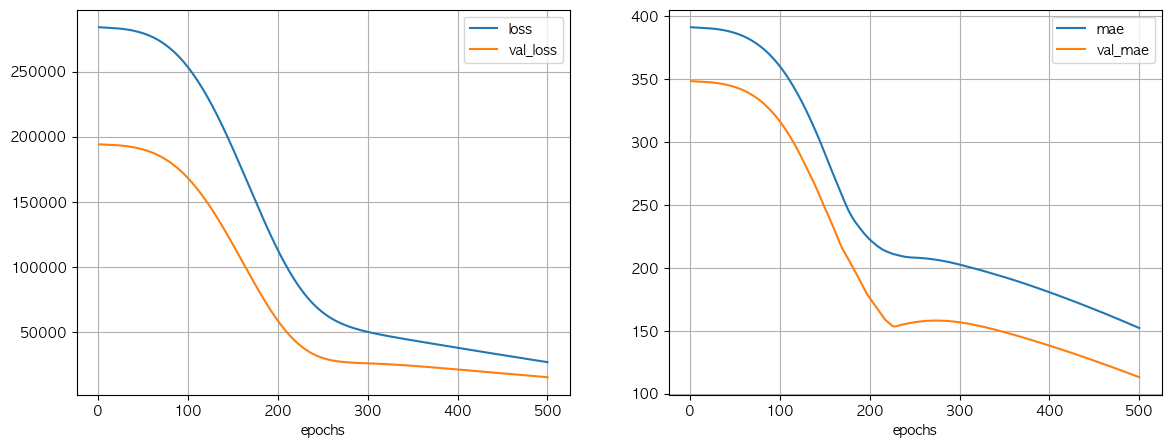

In [20]:
tf_result(result=result)

## #04. 최종 모듈 확인

### [1] 텐서 범용 함수


+-------+---------+---------+
|       |    loss |     mae |
|-------+---------+---------|
| train | 26797.8 | 151.917 |
| test  | 15304.6 | 113.096 |
+-------+---------+---------+


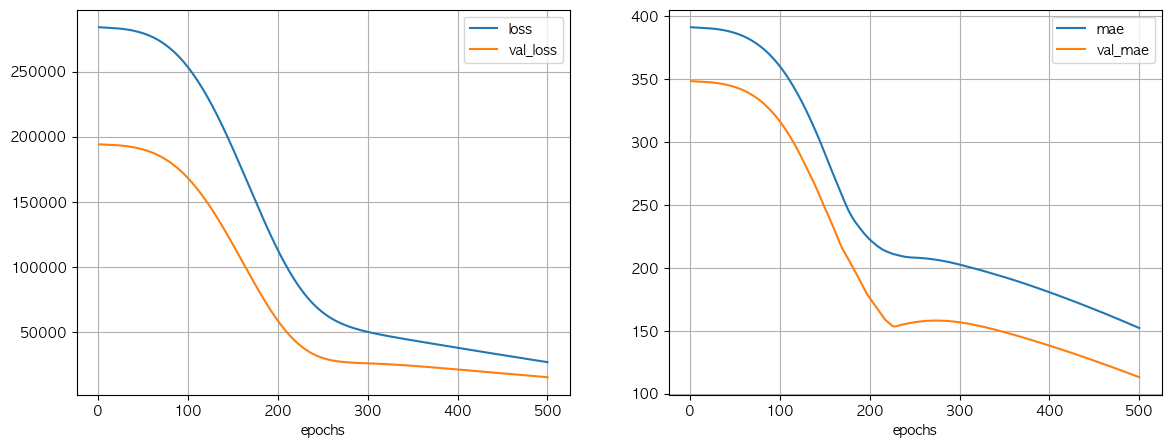

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,917 (27.02 KB)

 Trainable params: 2,305 (9.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,612 (18.02 KB)

In [21]:
my_tf(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    layer=[
        {"units": 64, "activation": "relu", "input_shape": (cols,)},
        {"units": 32, "activation": "relu"},
        {"units": 1, "activation": "linear"},
    ],
    optimizer="adam",
    loss="mse",
    metrics=["mae"],
).summary()

### [2] 선형 회귀 함수


Trial 15 Complete [00h 00m 02s]
val_mae: 347.0839538574219

Best val_mae So Far: 345.0764465332031
Total elapsed time: 00h 00m 26s
+-------+---------+---------+
|       |    loss |     mae |
|-------+---------+---------|
| train | 58401.6 | 209.827 |
| test  | 28240.1 | 160.582 |
+-------+---------+---------+


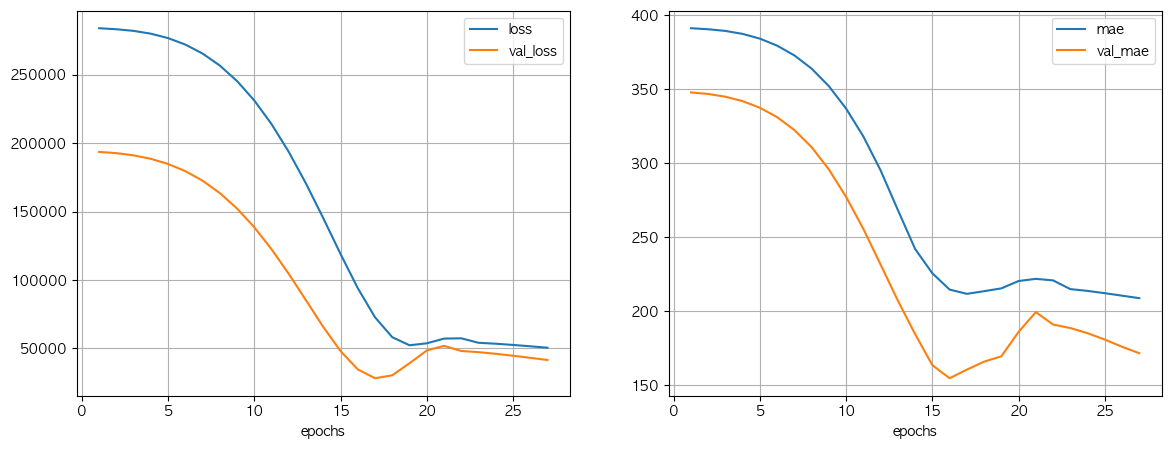

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,077 (199.52 KB)

 Trainable params: 17,025 (66.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,052 (133.02 KB)

In [22]:
tb_path = "D:\\tensorboard\\"
my_tf_linear(x_train, y_train, x_test, y_test, tensorboard_path=tb_path).summary()

## #06. Tensorboard 가동

vscode Tensorboard Extension 설치 후 수행
